In [48]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

sys.path.append("src.py")
from src import Utils

# get phospho data by itself
ptp_data = pd.read_pickle("./data/datasets/islets_PTP_dataset.pkl")
ptp_sample_metadata = pd.read_pickle("./data/datasets/islets_PTP_sample_metadata.pkl")
ptp_feature_metadata = pd.read_pickle("./data/datasets/islets_PTP_feature_metadata.pkl")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [F10] Phosphoproteomics 

Visualize phosphoproteomics differential results alongside functional score annotations


In [39]:
# ttest comparison between cell types (control only) for phospho data
ph_diff_exp = {}
for modality in ['proteomics', 'phosphoproteomics', 'transcriptomics']:
    for comparison in [['alpha','delta'], ['beta', 'delta'], ['alpha', 'beta']]:
        # Importantly, only consider control samples as no treatment was acquired in phospho data
        mask = ptp_sample_metadata['sample'].isin(comparison).values & ptp_sample_metadata['readout'].isin([modality]).values & ptp_sample_metadata['treat'].isin(['control']).values
        if sum(mask) != 6:
            raise ValueError(f"Expected 6 samples for {modality} {comparison} but got {sum(mask)}")
        ph_diff_exp[f"{modality}_{comparison[0]}_over_{comparison[1]}"] = Utils.group_ratios_ttest_ind(
            ptp_data[mask],
            ptp_sample_metadata[mask],
            between = 'sample'
        ).join(
            ptp_feature_metadata,
            how = 'left'
        )


In [54]:
# Data for 2D scatter plot of phosphoproteomics data and proteomics data
volcanoplot_datasets = {}
for comparison in [['alpha','delta'], ['beta', 'delta'], ['alpha', 'beta']]:

    key = f"{comparison[0]}_over_{comparison[1]}"
    columns = [f"delta_{key}", f"pvalue_{key}", f"padj_{key}", f"n_{comparison[0]}", f"n_{comparison[1]}"]

    phospho_data = ph_diff_exp[f"phosphoproteomics_{key}"][columns + ptp_feature_metadata.columns.tolist()]
    phospho_data.columns = [f"phosphoproteomics_{col}" for col in phospho_data.columns]
    proteomics_data = ph_diff_exp[f"proteomics_{key}"][columns]
    proteomics_data.columns = [f"proteomics_{col}" for col in proteomics_data.columns]
    
    combined_data = phospho_data.join(proteomics_data, how = 'inner')
    volcanoplot_datasets[key] = combined_data

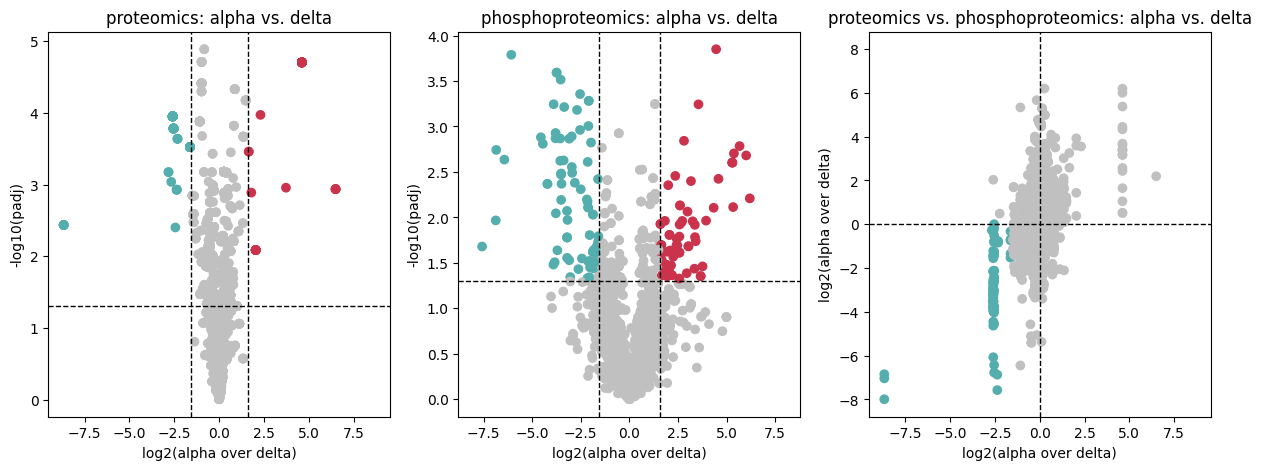

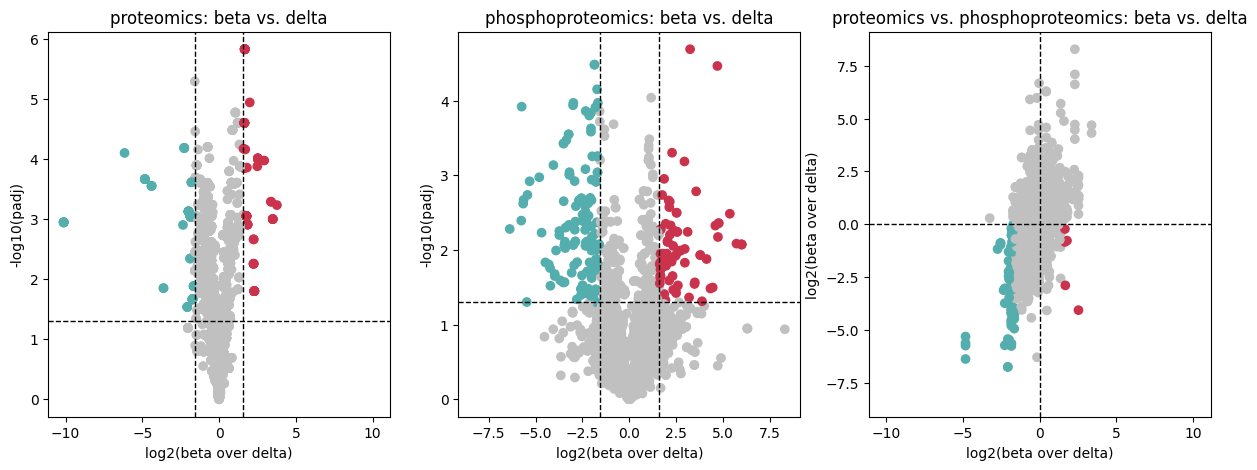

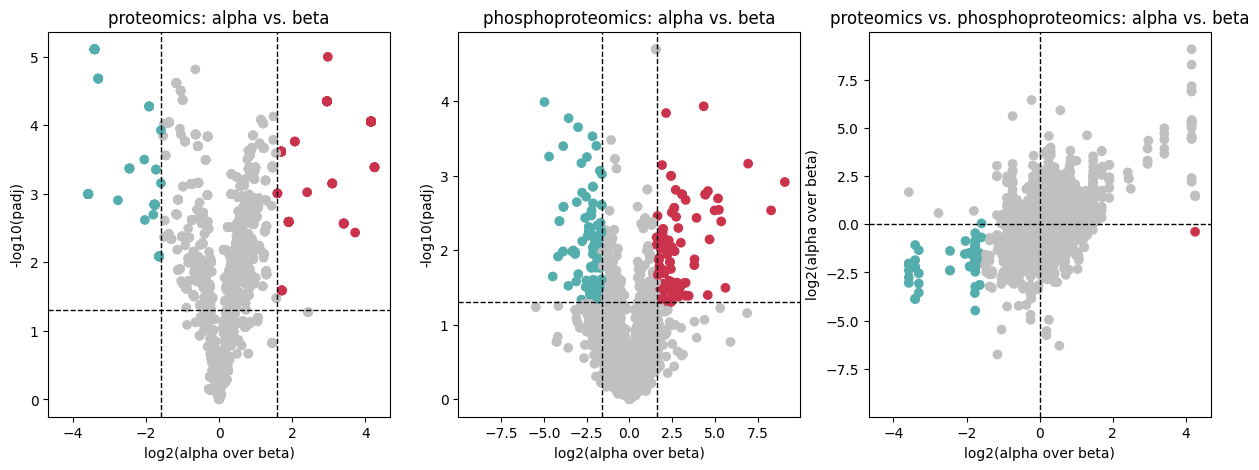

In [66]:
# 2D scatterplotting of phosphoproteomics data and proteomics data
P_LIM = 0.05
X_LIM = 3
LINEWIDTH = 1

colormap = {
    'not regulated': '#C0C0C0',
    'upregulated': '#cb334d',
    'downregulated': '#54aead',
    'selected' : '#3a7eb8',
}

pvalue = "pvalue" # or "pvalue"

differentially_regulated_sites = {}
for key, df in volcanoplot_datasets.items():
    
    # visualize and extract differentially regulated proteins
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    def _normal_volcanoplot(ax, df, readout, key):
        df = df.copy()

        # Specify axes
        x_col = f'{readout}_delta_{key}'
        y_col = f'{readout}_{pvalue}_{key}'

        # Add columns
        df[f'neg_log10_{y_col}'] = -np.log10(df[y_col])
        df['regulated'] = 'not regulated'
        df.loc[((df[x_col] > np.log2(X_LIM)) & (df[y_col] < P_LIM)), 'regulated'] = 'upregulated'
        df.loc[((df[x_col] < -np.log2(X_LIM)) & (df[y_col] < P_LIM)), 'regulated'] = 'downregulated'

        # plot volcano plot
        reg_colors = df['regulated'].map(colormap)
        ax.scatter(df[x_col], df[f'neg_log10_{y_col}'], c=reg_colors)
        x_outer = max(np.abs(df[x_col])) * 1.1
        ax.set_xlim(-x_outer, x_outer)
        
        ax.axhline(y=-np.log10(P_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
        ax.axvline(x=np.log2(X_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
        ax.axvline(x=-np.log2(X_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)

        ax.set_xlabel(f'log2({" ".join(key.split("_"))})')
        ax.set_ylabel('-log10(padj)')

        ax.set_title(f'{readout}: {key.replace("_over_", " vs. ")}')

    def _correlation_scatter(ax, df, readout_x, readout_y, key):
        df = df.copy()

        # Specify axes
        x_col = f'{readout_x}_delta_{key}'
        y_col = f'{readout_y}_delta_{key}'

        # Add columns
        df['regulated'] = 'not regulated'
        df.loc[((df[x_col] > np.log2(X_LIM)) & (df[y_col] < P_LIM)), 'regulated'] = 'upregulated'
        df.loc[((df[x_col] < -np.log2(X_LIM)) & (df[y_col] < P_LIM)), 'regulated'] = 'downregulated'

        # plot correlation scatter
        reg_colors = df['regulated'].map(colormap)
        ax.scatter(df[x_col], df[y_col], c=reg_colors)
        
        x_outer = max(np.abs(df[x_col])) * 1.1
        ax.set_xlim(-x_outer, x_outer)
        
        y_outer = max(np.abs(df[y_col])) * 1.1
        ax.set_ylim(-y_outer, y_outer)

        ax.axhline(y=0, color='black', linestyle='--', linewidth=LINEWIDTH)
        ax.axvline(x=0, color='black', linestyle='--', linewidth=LINEWIDTH)

        ax.set_xlabel(f'log2({" ".join(key.split("_"))})')
        ax.set_ylabel(f'log2({" ".join(key.split("_"))})')
        ax.set_title(f'{readout_x} vs. {readout_y}: {key.replace("_over_", " vs. ")}')

    for i, readout in enumerate([['proteomics'], ['phosphoproteomics'], ['proteomics', 'phosphoproteomics']]):
        if len(readout) == 1:
            readout = readout[0]
            _normal_volcanoplot(axs[i], df, readout, key)
        else:
            readout_x = readout[0]
            readout_y = readout[1]
            _correlation_scatter(axs[i], df, readout_x, readout_y, key)

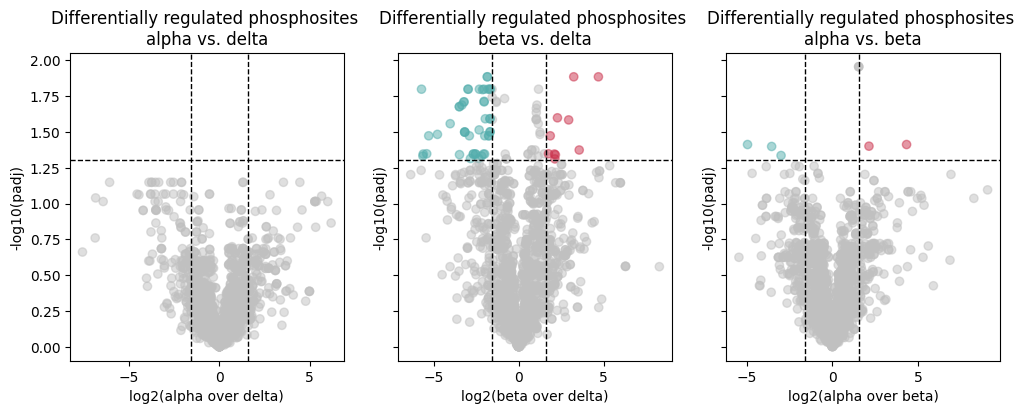

In [23]:
import numpy as np
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey = True)

# visualize and extract differentially regulated proteins
differentially_regulated_sites = {}
for i, (comparison, diff_exp) in enumerate(ph_diff_exp.items()):

    P_LIM = 0.05
    X_LIM = 3
    LINEWIDTH = 1

    x_col = f'delta_{comparison}'
    y_col = f'padj_{comparison}'

    diff_exp[f'neg_log10_{y_col}'] = -np.log10(diff_exp[y_col])

    diff_exp['regulated'] = 'not regulated'
    diff_exp.loc[((diff_exp[x_col] > np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'upregulated'
    diff_exp.loc[((diff_exp[x_col] < -np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'downregulated'

    colormap = {
        'not regulated': '#C0C0C0',
        'upregulated': '#cb334d',
        'downregulated': '#54aead',
        'selected' : '#3a7eb8',
    }

    differentially_regulated_sites[comparison] = diff_exp[diff_exp['regulated'].isin(['upregulated', 'downregulated'])].copy()

    # plot volcano plot
    ax = axs[i]

    reg_colors = diff_exp['regulated'].map(colormap)
    ax.scatter(diff_exp[x_col], diff_exp[f'neg_log10_{y_col}'], c=reg_colors, alpha=0.5)
    
    ax.axhline(y=-np.log10(P_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
    ax.axvline(x=np.log2(X_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
    ax.axvline(x=-np.log2(X_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)

    ax.set_xlabel(f'log2({" ".join(comparison.split("_"))})')
    ax.set_ylabel('-log10(padj)')

    ax.set_title(f'Differentially regulated phosphosites \n{comparison.replace("_over_", " vs. ")}')

In [ ]:
# Cross-reference with protein differential expression: fold change of protein data has to be correlated with phospho data to identify phosphorylation sites that change in abundance independently of protein abundance


## Retrieve functional annotation from literature data

Referencing a study by Lancaster et al. (Coon lab, 2025) [Lancaster, Noah M., et al. "Fast and deep phosphoproteome analysis with the Orbitrap Astral mass spectrometer." Nature communications 15.1 (2024): 7016.], we seek to relate differentially regulated phosphosites to molecular function.



### Appendix: Mouse-to-Human mapping

In [74]:
# get Mouse to Human gene mapping from the ENSEMBL databaset:
# http://www.ensembl.org/biomart/martview/775974b699d308980b35a596a385b751?VIRTUALSCHEMANAME=default&ATTRIBUTES=mmusculus_gene_ensembl.default.homologs.ensembl_gene_id|mmusculus_gene_ensembl.default.homologs.ensembl_gene_id_version|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id_version|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_gene|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_associated_gene_name|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_perc_id|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_peptide|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_type|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_confidence|mmusculus_gene_ensembl.default.homologs.external_gene_name&FILTERS=&VISIBLEPANEL=resultspanel
mouse2human = pd.read_csv("./mouse2human_ortholog_mapping.txt", header = 0).dropna(subset=["Human gene name"])

# Handle mapping of ENSEMBL to uniprot IDs using bioMart. Prefer static version of mapping dict due to possible API changes
mapping_dict_name = "2025-04-30_10_37_56_hsapiens_ref_dict.pkl"
if not os.path.exists("2025-04-30_10_37_56_hsapiens_ref_dict.pkl"):
    mapping_dict_name = f"./{pd.Timestamp.now().strftime('%Y-%m-%d_%H_%M_%S')}_hsapiens_ref_dict.pkl"
    hsapiens_ref_dict = Utils.map_ensembl_to_uniprot('hsapiens', True)
    pd.DataFrame.from_dict(hsapiens_ref_dict, orient = 'index', columns = ['uniprot_id']).to_pickle(mapping_dict_name)
hsapiens_ref_dict = pd.read_pickle(mapping_dict_name)['uniprot_id'].to_dict()

def add_human_uniprot_ids_to_mouse2human(
    mouse2human: pd.DataFrame,
    hsapiens_ref_dict: dict,
):
    # Get mouse2human['human_UniProtID'] by mapping mouse2human['Human gene stable ID'] to human_ensembl2uniprot
    mouse2human['human_UniProtID'] = mouse2human['Human gene stable ID'].map(hsapiens_ref_dict)
    return mouse2human

mouse2human = add_human_uniprot_ids_to_mouse2human(mouse2human, hsapiens_ref_dict)